In [ ]:
!pip install tensorflow-addons
!pip install git+https://www.github.com/keras-team/keras-contrib
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/My Drive/master thesis/code/xai-tsc

  Cloning https://www.github.com/keras-team/keras-contrib to /tmp/pip-req-build-xp4sumkn
  Running command git clone --filter=blob:none --quiet https://www.github.com/keras-team/keras-contrib /tmp/pip-req-build-xp4sumkn
  Resolved https://www.github.com/keras-team/keras-contrib to commit 3fc5ef709e061416f4bc8a92ca3750c824b5d2b0
  Preparing metadata (setup.py) ... done
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/master thesis/code/xai-tsc


In [ ]:
def norm(values):
    if not type(values) == np.ndarray:
        return normalize(values.numpy().reshape(1,-1))[0]
    else:
        return normalize(values.reshape(1,-1))[0]

In [ ]:
dataset = 'GunPoint'
model_type = 'resnet'
model = 'resnet'
itr = 0
root_dir =  '/content/drive/My Drive/master thesis/code/xai-tsc'
#"/content/drive/My Drive/master thesis/code/xai-tsc"
#'G:/Meine Ablage/master thesis/code/xai-tsc'

#'G:/Meine Ablage/master thesis/code/xai-tsc'
archive = 'ucr'
dataset_name = 'GunPoint'
archive_name = 'ucr'
task  = 1
data_source = 'original'


import tensorflow_addons as tfa
from utils.explanations import integrated_gradients
from utils.explanations import calculate_cam_attributions,calculate_shap_attributions
from keras.utils import CustomObjectScope
import tensorflow.keras as keras
import tensorflow as tf
import os
from utils.explanations import minmax_norm
from utils.explanations import calculate_ig_attributions
#from utils.explanations import calculate_cam_attributions
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utils.utils import read_dataset
from sklearn.preprocessing import normalize
import numpy as np
import sklearn




def get_new_training_data(model, itr, dataset_name, att_method):
    #Hardcoded --> Rework

    archive = 'ucr'
    #Load Dataset
    datasets_dict = read_dataset(root_dir, archive_name, dataset_name, 'original', 1)
    x_train, y_train, x_test, y_test = datasets_dict[dataset_name]

    #calcualte attributions
    if att_method == 'cam':
        attributions = calculate_cam_attributions(root_dir, archive, f"{model}_{itr}", dataset_name, 'original',  experiment=1, scale='normalized')
    elif att_method == 'ig':
        attributions = calculate_ig_attributions(root_dir, archive, f"{model}_{itr}", dataset_name, 'original',  experiment=1, scale='normalized')
    elif att_method == 'shap':
        pass
        #attributions = calculate_shap_attributions(root_dir, archive, f"{model}_{itr}", dataset_name, 'original',  experiment=1, scale='normalized')


    #transform labels
    enc = sklearn.preprocessing.OneHotEncoder(categories='auto')
    enc.fit(np.concatenate((y_train, y_test), axis=0).reshape(-1, 1))
    y_train = enc.transform(y_train.reshape(-1, 1)).toarray()
    y_test = enc.transform(y_test.reshape(-1, 1)).toarray()
    #Calculate y values for output 2
    y_train_2 = []
    for e in attributions[0]:
        y_train_2.append(e[2])
    y_train_2 = np.array(y_train_2)
    y_test_2 = []
    for e in attributions[1]:
        y_test_2.append(e[2])
    y_test_2 = np.array(y_test_2)

    return x_train, y_train, y_train_2, x_test, y_test, y_test_2

x_train, y_train, y_train_2, x_test, y_test, y_test_2 = get_new_training_data('fcn', 0, 'ECG200', 'cam')


x_train.shape, y_train.shape, y_train_2.shape, y_test_2.shape

((100, 96), (100, 2), (100, 96), (100, 96))

In [25]:

from utils.explanations import get_layer_index
from utils.constants import CAM_LAYERS
import pandas as pd
import matplotlib.pyplot as plt
from utils.explanations import norm

def predict_attributions_head_2(model, dataset_name, att_method):

    ITERATIONS = 1

    results = pd.DataFrame(columns=["linear_output","conv1d_output","build_deep_nn","build_encoder"])

    for itr in range(ITERATIONS):
        print( f'./results/ucr/{dataset_name}/experiment_1/{model}/{model}_{itr}/original/best_model.hdf5')
        model_link  = f'./results/ucr/{dataset_name}/experiment_1/{model}/{model}_{itr}/original/best_model.hdf5'
        loaded_model = keras.models.load_model(model_link ,compile=False)

        x_train, y_train, y_train_2, x_test, y_test, y_test_2 = get_new_training_data(model, itr, dataset_name,  att_method)
        #Sanity Check 1: Check if layers are really freezed by checking prediction
        pred1 = loaded_model.predict(x_train)[0]

        #yvals = 2
        ylen = len(x_train[0])

        # Existing model
        existing_model = loaded_model  # Your existing model

        # Select the index of the layer until which you want to freeze
        freeze_until_layer_index = get_layer_index(loaded_model,CAM_LAYERS[model]["last_conv_layer"])

        # Create a new model with frozen layers
        frozen_model = tf.keras.Model(inputs=existing_model.input, outputs=existing_model.layers[freeze_until_layer_index].output)

        weights_for_output_1 = existing_model.layers[get_layer_index(existing_model,'task_1_output')].get_weights()

        # Freeze the layers of the frozen_model
        for layer in frozen_model.layers:
            layer.trainable = False

        # Create new output functions
        output_function_1 = tf.keras.layers.GlobalAveragePooling1D()(frozen_model.output)

        output_function_1 = tf.keras.layers.Dense(len(y_train[0]), activation='softmax', trainable=False, name='task_1_output')(output_function_1)

        #Flatten Output Intermediate
        flatten = keras.layers.Flatten()(frozen_model.output)
        #Conv1D  Output Intermediate
        conv1d = keras.layers.Conv1DTranspose(filters=20, kernel_size=3,padding='same',activation="linear")(frozen_model.output)
        conv1d_flatten =  keras.layers.Flatten()(conv1d)


        def linear_output():
            output_function_2 = tf.keras.layers.Dense(ylen, activation='linear', name='task_2_output')(flatten)
            return output_function_2

        def conv1d_output():
            output_function_2 =  keras.layers.Conv1D(filters=1, kernel_size=3,padding='same',activation="linear", name='task_2_output')(frozen_model.output)
            return output_function_2

        #Deep Neural Network
        def build_deep_nn():
            interm_function_1 = tf.keras.layers.Dense(2*ylen, activation='relu')(flatten)
            interm_function_2 = tf.keras.layers.Dense(2*ylen, activation='relu')(interm_function_1)
            interm_function_3 = tf.keras.layers.Dense(2*ylen, activation='relu')(interm_function_2)
            output_function_2 = tf.keras.layers.Dense(ylen, activation='linear', name='task_2_output')(interm_function_3)
            return output_function_2


        def build_encoder():
            conv4 = keras.layers.Conv1DTranspose(filters=128, kernel_size=3, padding='same')(frozen_model.output)
            conv4 = keras.layers.Activation('relu')(conv4)
            conv5 = keras.layers.Conv1DTranspose(filters=256, kernel_size=5, padding='same')(conv4)
            conv5 = keras.layers.Activation('relu')(conv5)
            conv6 = keras.layers.Conv1DTranspose(filters=128, kernel_size=8, padding='same')(conv5)
            conv6 = keras.layers.Activation('relu')(conv6)
            output_function_2 = keras.layers.Conv1DTranspose(filters=1, kernel_size=3,padding='same',activation="linear",name='task_2_output')(conv6)
            return output_function_2

        #Loop over task specific heads:
        heads = [linear_output, conv1d_output, build_deep_nn,build_encoder] #conv1d_output, build_encoder
        metric_pd = dict()
        graphics = dict()
        for head in heads:

            output_function_2 = head()

            # Create the final model with frozen layers and new output functions
            final_model = tf.keras.Model(inputs=frozen_model.input, outputs=[output_function_1, output_function_2])

            for layer in final_model.layers:
                if 'shared' in layer.name or 'task_1_output' in layer.name:
                    layer.trainable = False

            weights = final_model.get_weights()

            final_model.compile(
            optimizer = keras.optimizers.Adam(),
            loss={'task_1_output': 'categorical_crossentropy','task_2_output': 'mse'},
            loss_weights={'task_1_output': 0, 'task_2_output': 1},
            metrics=['accuracy'])

            final_model.set_weights(weights)
            final_model.layers[get_layer_index(final_model,'task_1_output')].set_weights(weights_for_output_1)

            metric = "loss"

            hist = final_model.fit(
            {'input_1': x_train},
            {'task_1_output': y_train, 'task_2_output': y_train_2},
            batch_size=3,
            epochs= 400,
            verbose=False,
            validation_data=(
                x_test,
                {'task_1_output': y_test, 'task_2_output': y_test_2}))

            pred2 = final_model.predict(x_train)[0][0]
            #Check if Predictions after training remain the same:
            if not (pred1==pred2)[0]: break
            mean_corr = 0
            pred = final_model.predict(x_test)[1]
            for ts in range(len(x_test)):
                mean_corr += np.corrcoef(y_test_2[ts],pred[ts].flatten())[0,1]

            metric_pd[head.__name__] = {
                f"min_mse_{itr}" : np.min(hist.history['val_' + metric]),
                f"min_epo_{itr}" : int(np.argmin(hist.history['val_' + metric])),
                f"mean_corr_test_{itr}" : mean_corr / len(x_test) }

            # Plot example for test data

            graphics[head.__name__] = {
                "true_values": y_test_2[0],
                "prediction" : pred[0].flatten()
            }

        #results = results.append(pd.DataFrame(metric_pd), ignore_index=True)
        plt.figure()
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
        # tanh_output,conv1d_output, build_deep_nn,build_encoder
        #linear
        j = 0
        p = 0
        for i,k in enumerate(graphics.keys()):
            tt = ["Linear", "1x1 Convolution", "Deep Neural Network", "Mirrored Architecture"]
            print(p,j)
            if i == 2: j=0; p=1
            axes[p][j].plot(np.arange(len(graphics[k]["true_values"])),graphics[k]["true_values"], label="Target Feature Attribution")
            axes[p][j].plot(np.arange(len(graphics[k]["prediction"])),graphics[k]["prediction"], label="Predicted Feature Attribution")
            axes[p][j].legend(loc="lower right",prop={'size': 20})
            axes[p][j].set_title(tt[i])
            j+=1

        #plt.savefig(f'./results_csv/Experiment1b/{model}_{att_method}_sample_plot_1b_{dataset}_bar.png')
        fig.suptitle(f"Feature Attribution Prediction for {dataset_name} dataset", fontsize=24)
        fig.supxlabel(f"Timesteps", fontsize=12)
        fig.supylabel(f"Feature Attribution Score", fontsize=12)
        plt.tight_layout()
        plt.show()
        plt.draw

        plt.figure()
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 8))
        # tanh_output,conv1d_output, build_deep_nn,build_encoder
        #linear
        pos = 0
        for i,k in enumerate(graphics.keys()):
            tt = ["Deep Neural Network", "Mirrored Architecture"]
            if k == "linear_output" or k == "conv1d_output":  continue
            print(pos)
            axes[pos].plot(np.arange(len(graphics[k]["true_values"])),graphics[k]["true_values"], label="Target Feature Attributions")
            axes[pos].plot(np.arange(len(graphics[k]["prediction"])),graphics[k]["prediction"], label="Predicted Freature Attributions")
            axes[pos].plot(norm(x_test[0]), linewidth = 2, color = "black", label="Timeseries")
            axes[pos].legend(loc = "lower right",prop={'size': 24})
            axes[pos].set_title(tt[pos])
            pos += 1
        fig.suptitle(f"Feature Attribution Prediction for {dataset_name} dataset", fontsize=24)
        fig.supxlabel(f"Timesteps", fontsize=12)
        fig.supylabel(f"Feature Attribution Score", fontsize=12)
        #plt.savefig(f'./results_csv/Experiment1b/{model}_{att_method}_sample_plot_1b_{dataset}_seq.png')
        plt.tight_layout()
        plt.show()
        plt.draw

        #results.to_csv(f"./results_csv/Experiment1b/{dataset_name}_{model}_{att_method}_{itr}.csv")

        return results



./results/ucr/GunPoint/experiment_1/fcn/fcn_0/original/best_model.hdf5
/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/fcn/fcn_0/original/best_model.hdf5
5/5 [==============================] - 0s 18ms/step
0 0
0 1
0 2
1 1


<Figure size 640x480 with 0 Axes>

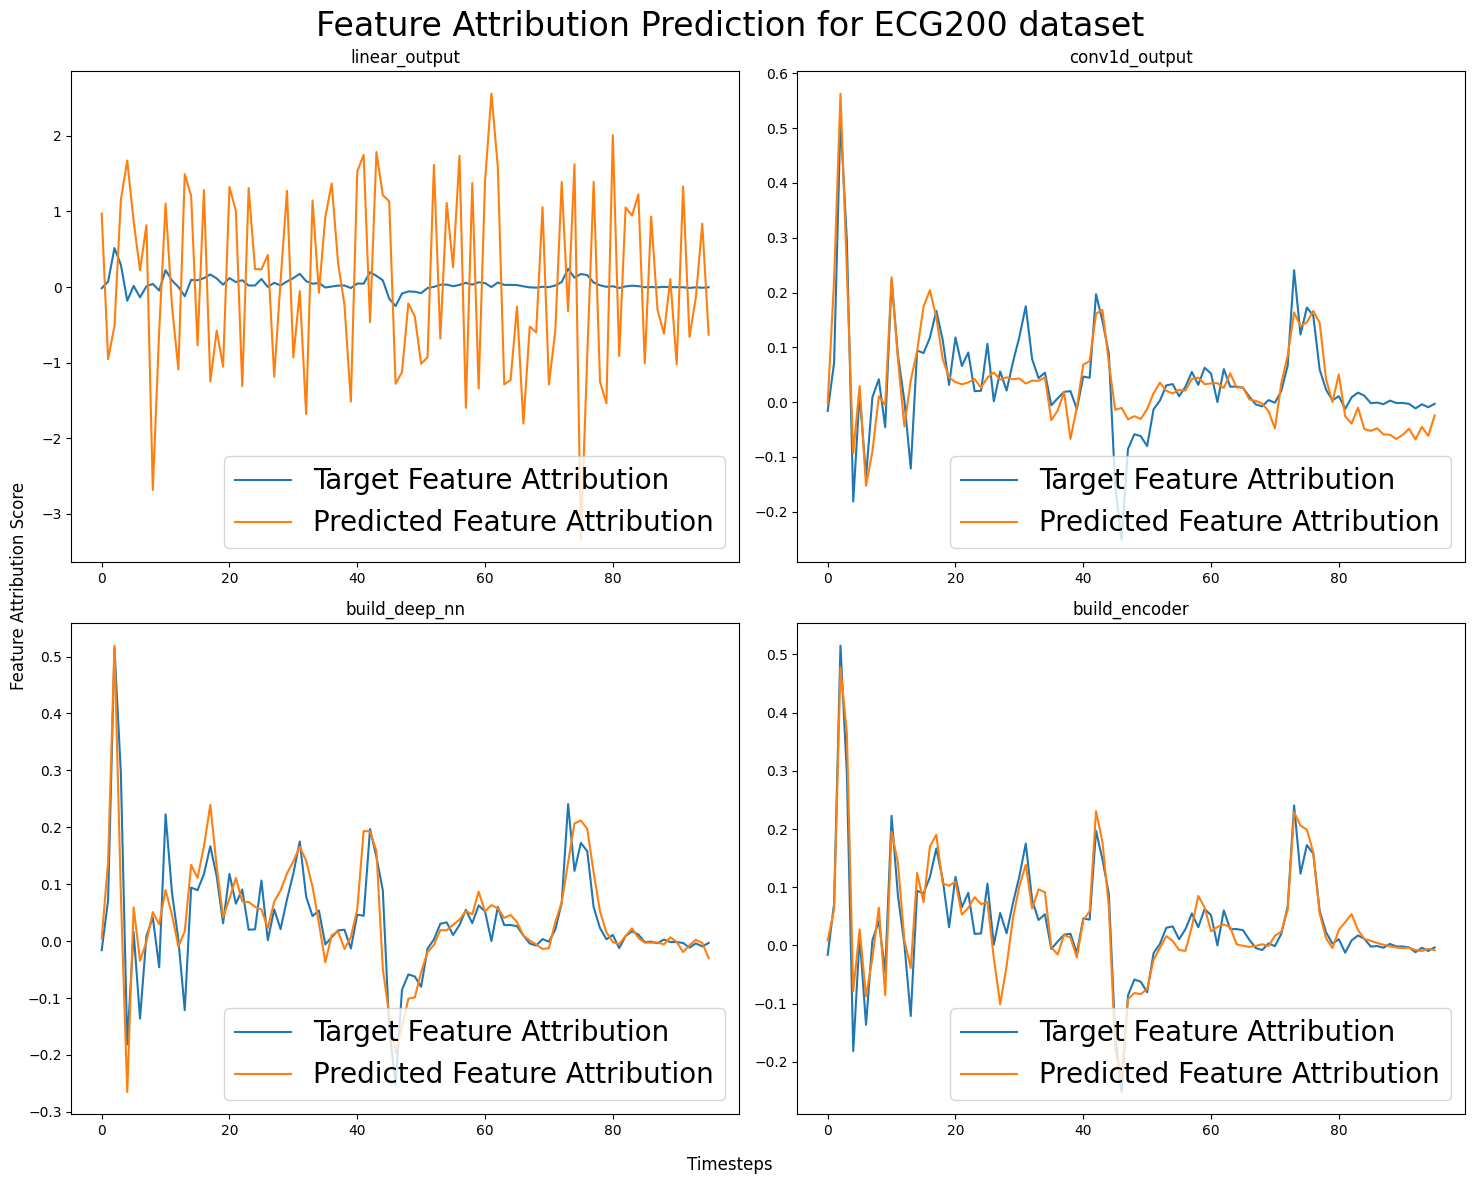

<Figure size 640x480 with 0 Axes>

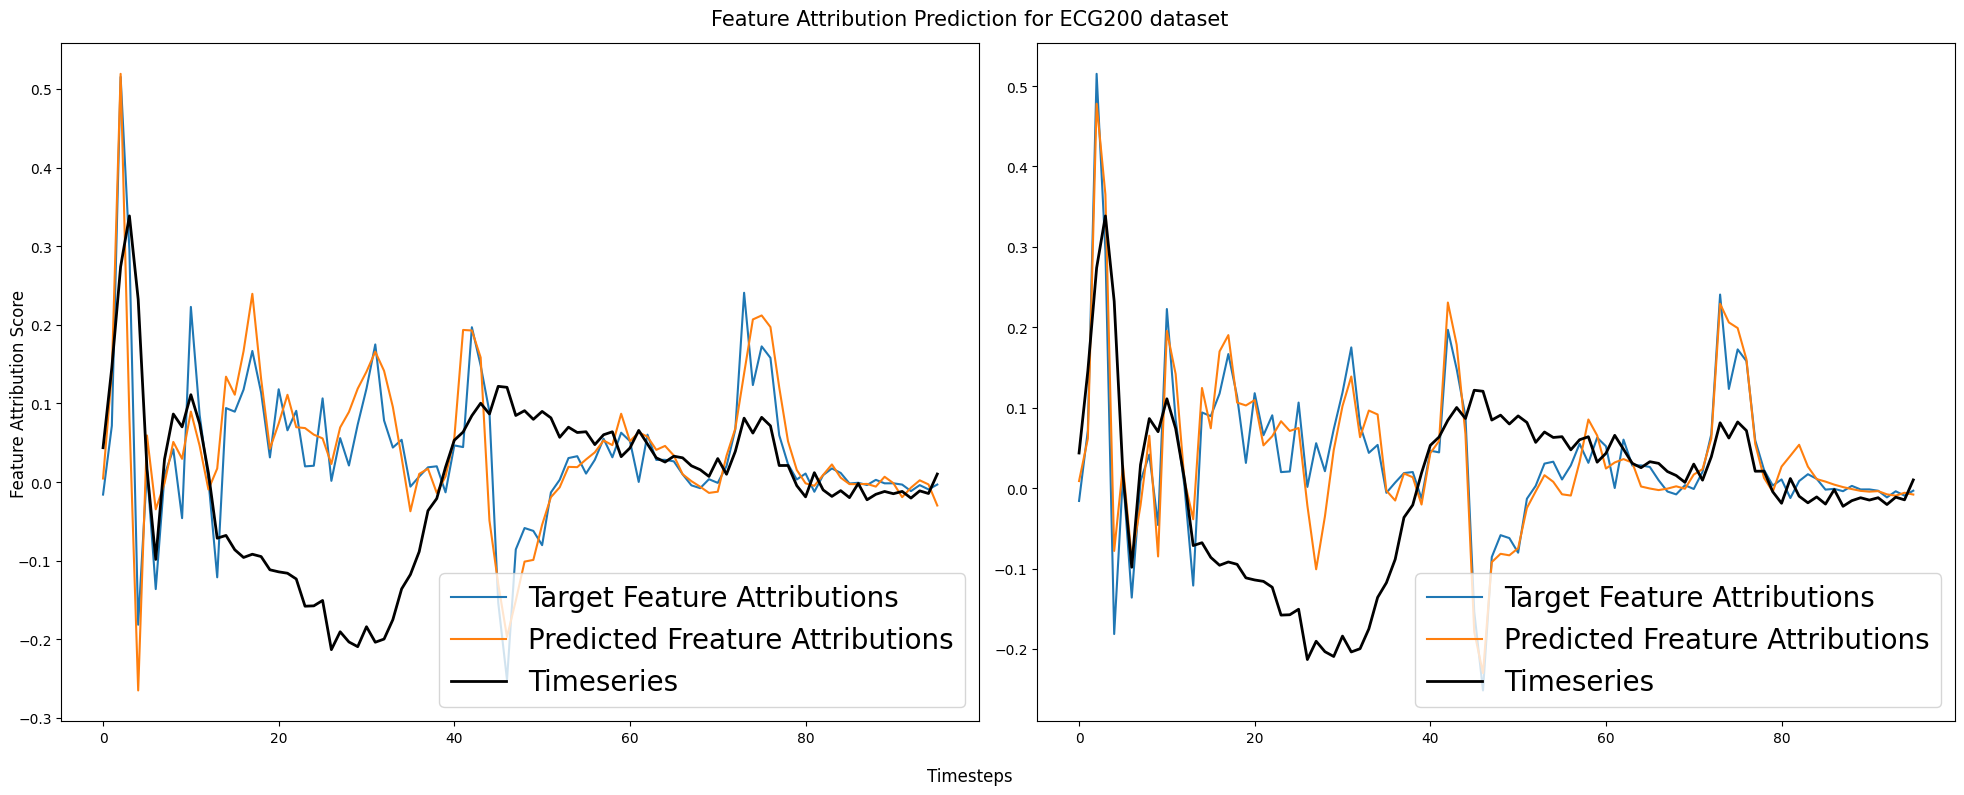

<Figure size 640x480 with 0 Axes>

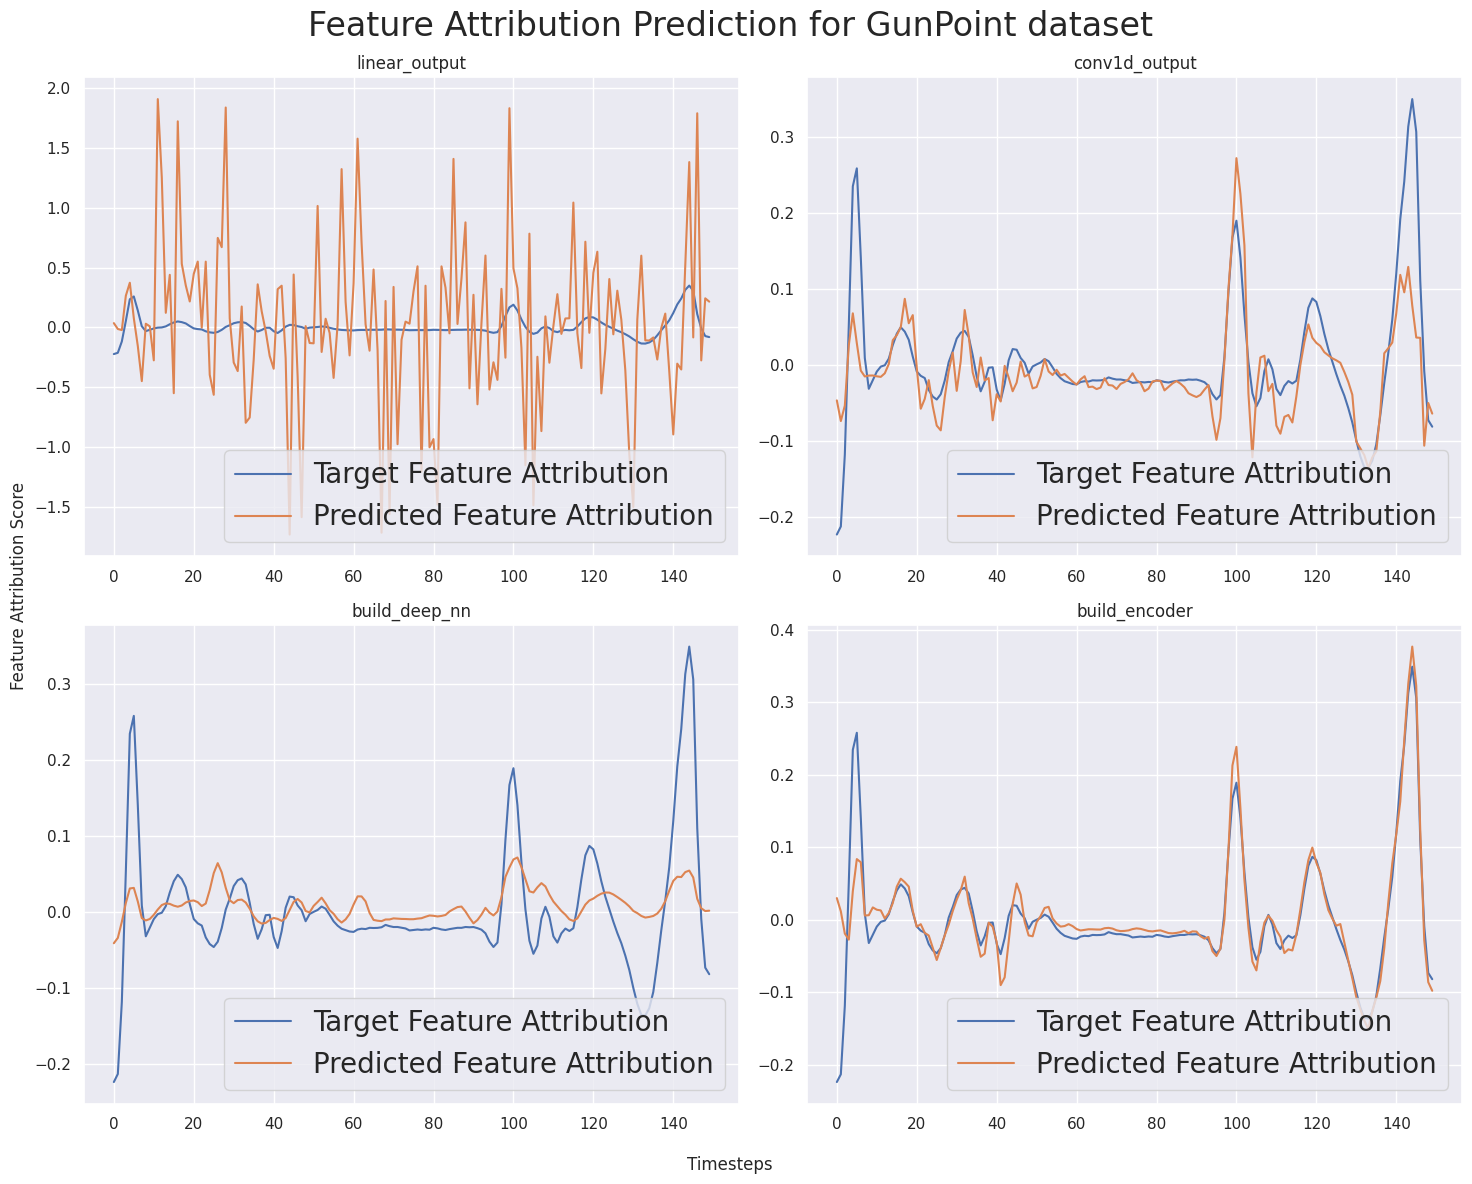

0
1


<Figure size 640x480 with 0 Axes>

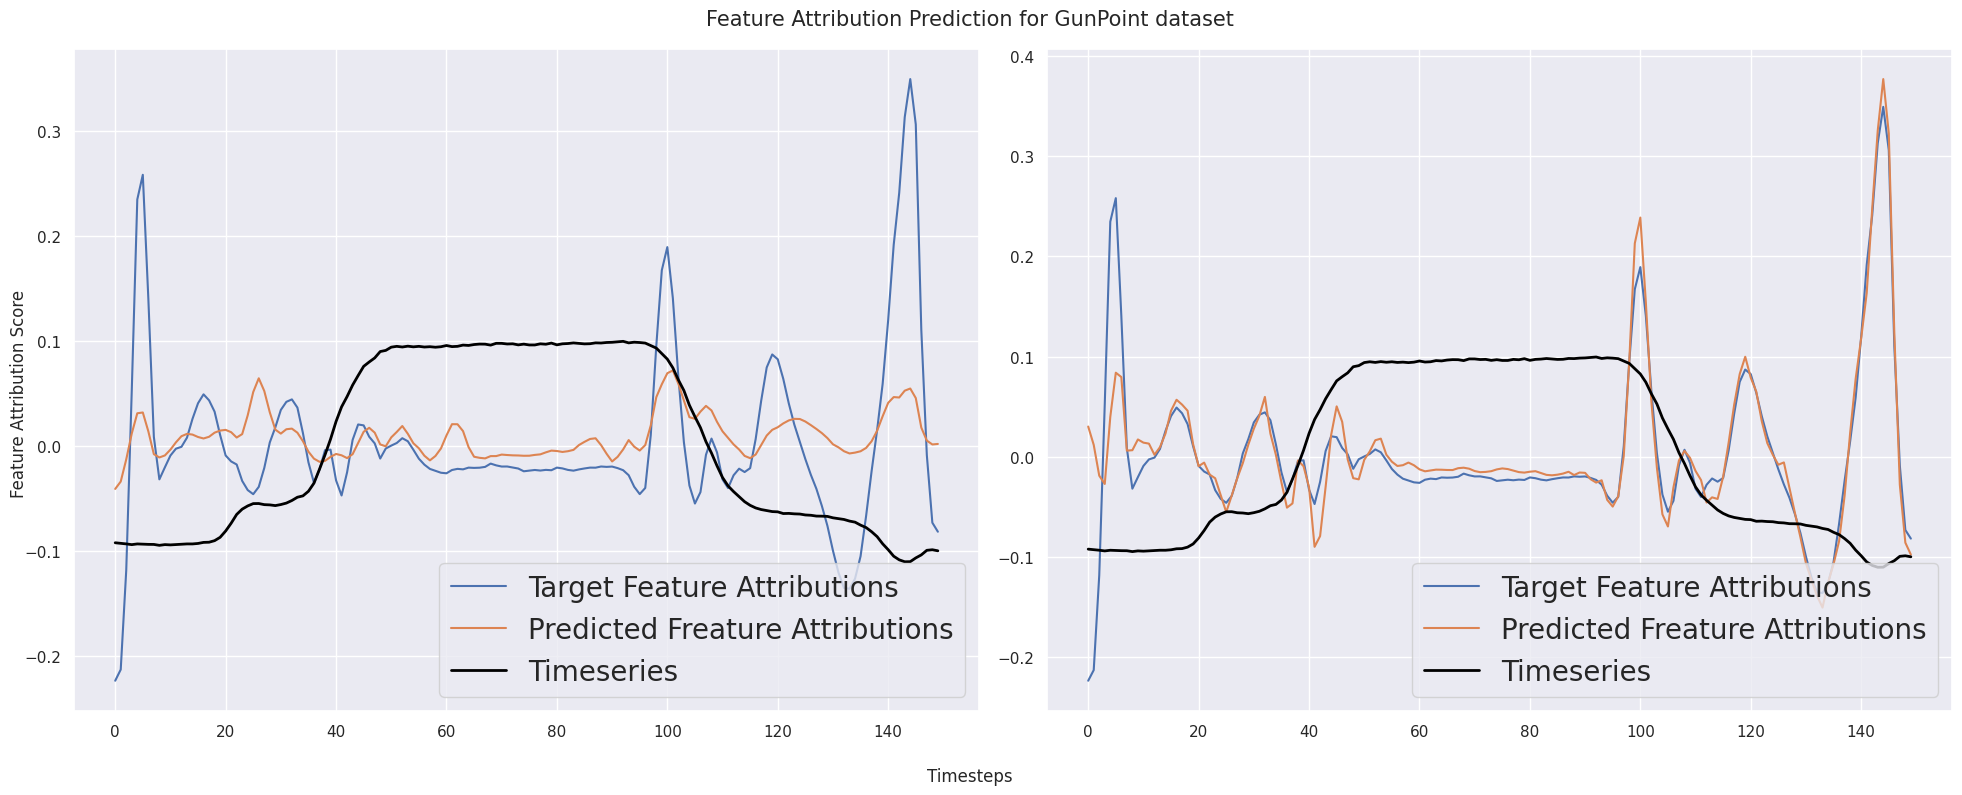

,linear_output,conv1d_output,build_deep_nn,build_encoder


In [ ]:
%matplotlib inline
import seaborn as sns
sns.set()
dataset_name = 'GunPoint'
fcn_ig = predict_attributions_head_2('fcn', dataset_name,'ig')
display(fcn_ig)

### GunPoint

In [ ]:
dataset_name = 'GunPoint'
resnet_ig = predict_attributions_head_2('resnet', dataset_name,'ig')
display(resnet_ig)

./results/ucr/GunPoint/experiment_1/resnet/resnet_0/original/best_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_0/original/best_model.hdf5
5/5 [==============================] - 0s 57ms/step


C:\Users\boent\AppData\Local\Temp\ipykernel_14212\2465729710.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd), ignore_index=True)
C:\Users\boent\AppData\Local\Temp\ipykernel_14212\2465729710.py:147: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\boent\AppData\Local\Temp\ipykernel_14212\2465729710.py:162: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,linear_output,conv1d_output,build_deep_nn,build_encoder
0,2.387280,0.005157,0.004438,0.002218
1,161.000000,391.000000,353.000000,253.000000
2,0.049158,0.524453,0.532717,0.806309


./results/ucr/GunPoint/experiment_1/fcn/fcn_0/original/best_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/fcn/fcn_0/original/best_model.hdf5
5/5 [==============================] - 0s 24ms/step


C:\Users\boent\AppData\Local\Temp\ipykernel_5228\3507783634.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd), ignore_index=True)


<Figure size 640x480 with 0 Axes>

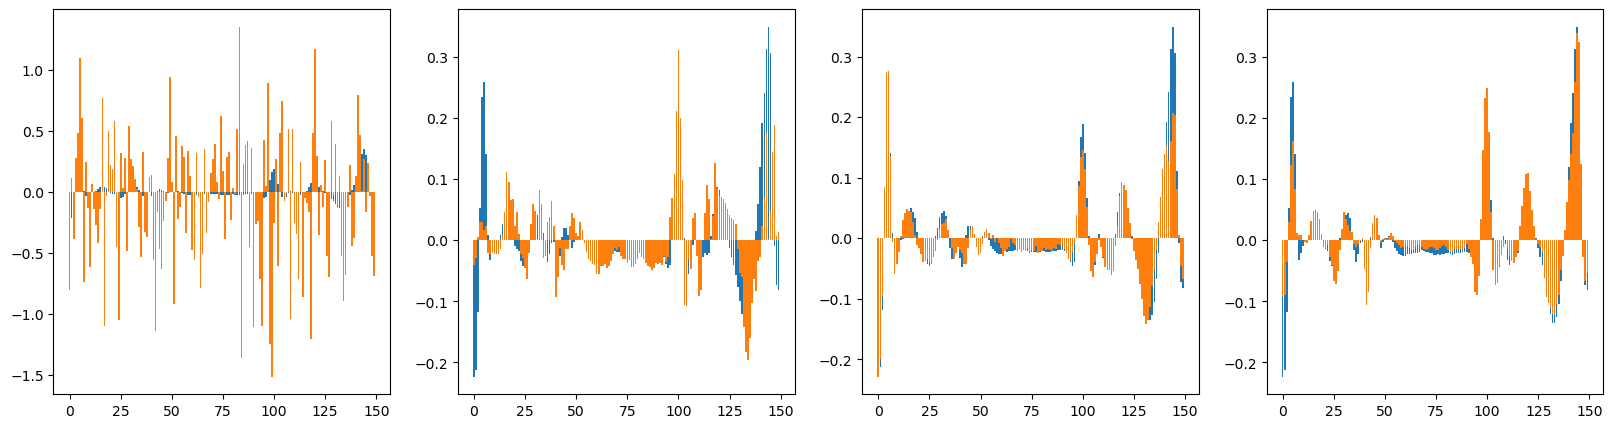

<Figure size 640x480 with 0 Axes>

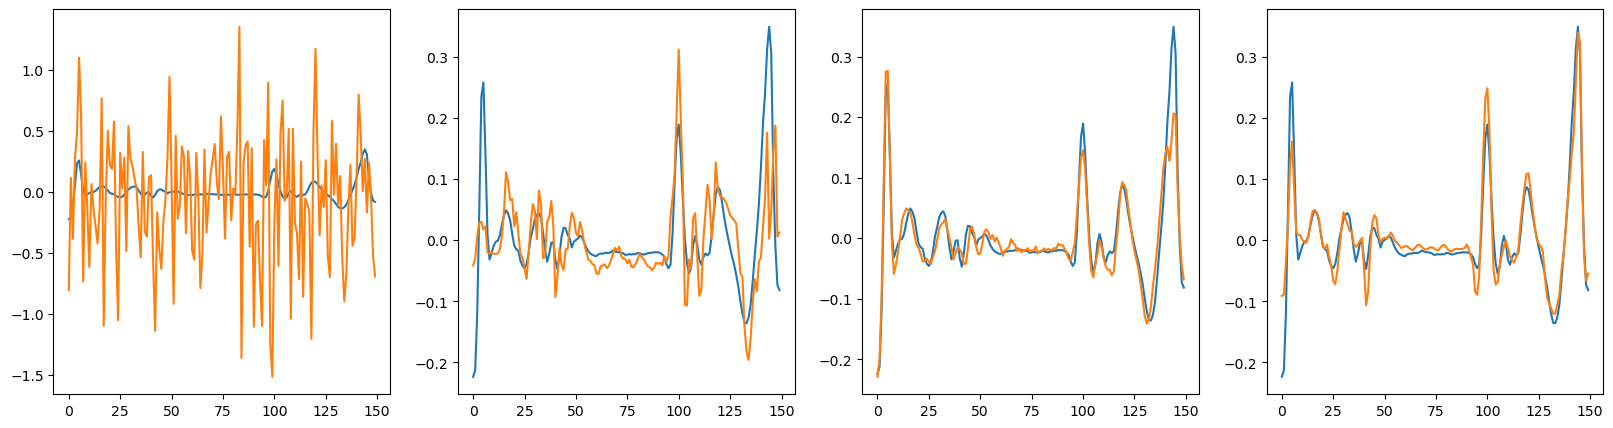

,linear_output,conv1d_output,build_deep_nn,build_encoder
0,0.531112,0.007226,0.005317,0.002616
1,56.000000,97.000000,92.000000,85.000000
2,0.012017,0.410308,0.384471,0.778850


In [ ]:
dataset_name = 'GunPoint'
fcn_ig = predict_attributions_head_2('fcn', dataset_name,'ig')
display(fcn_ig)

./results/ucr/GunPoint/experiment_1/resnet/resnet_0/original/best_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/GunPoint//experiment_1/resnet/resnet_0/original/best_model.hdf5
5/5 [==============================] - 0s 31ms/step


C:\Users\boent\AppData\Local\Temp\ipykernel_5228\3507783634.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd), ignore_index=True)


<Figure size 640x480 with 0 Axes>

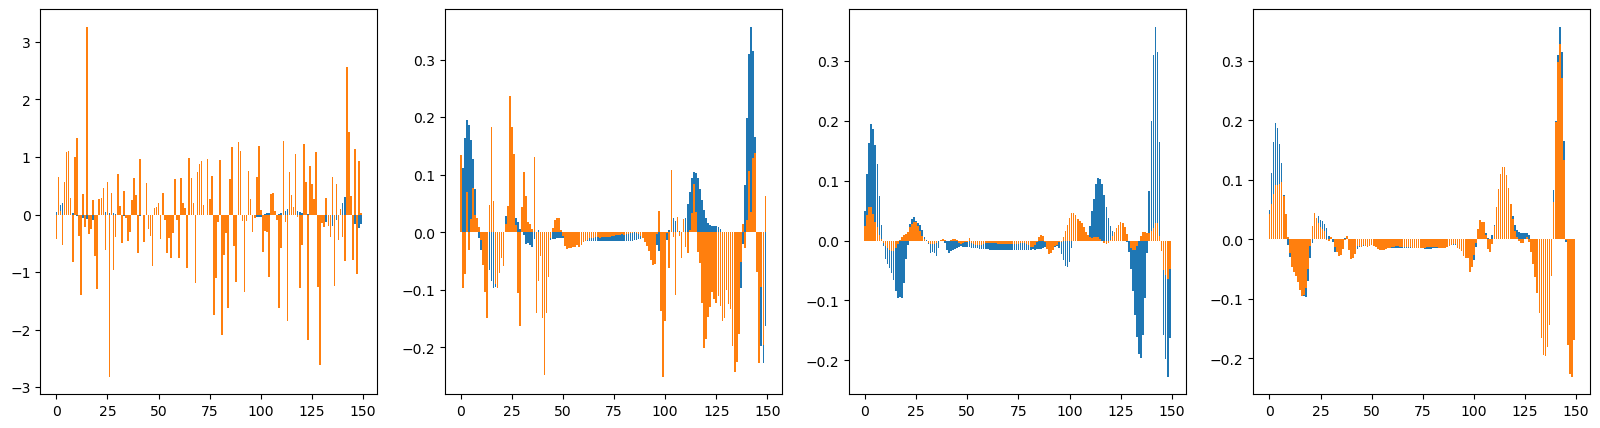

<Figure size 640x480 with 0 Axes>

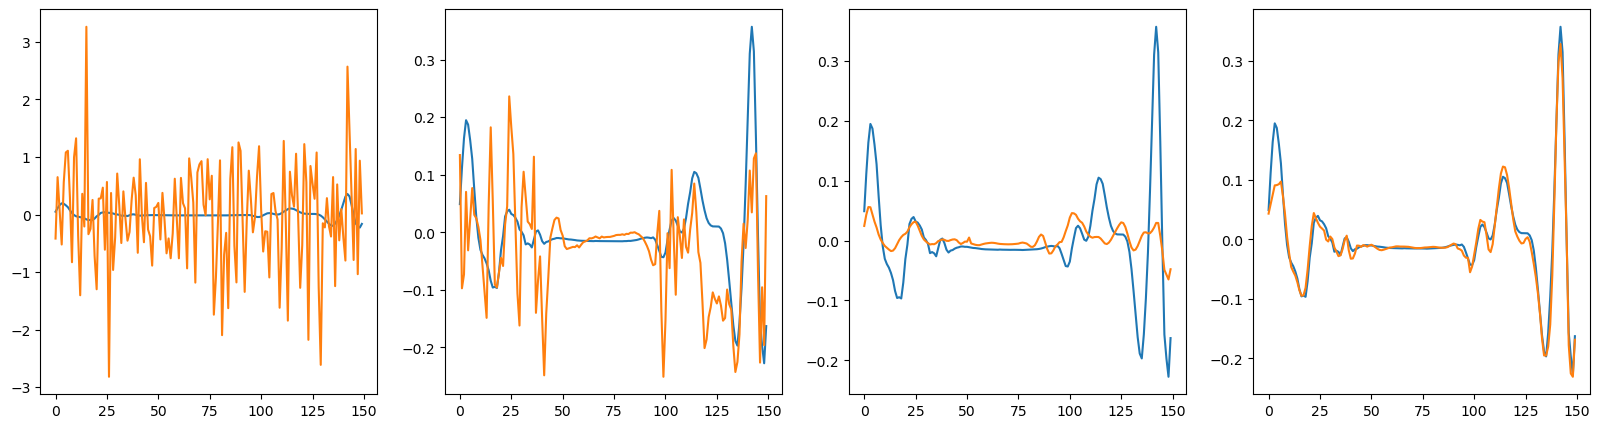

,linear_output,conv1d_output,build_deep_nn,build_encoder
0,2.321883,0.012526,0.006442,0.002316
1,96.000000,95.000000,68.000000,93.000000
2,0.033339,0.292349,0.219169,0.808991


In [ ]:
dataset_name = 'GunPoint'
resnet_ig = predict_attributions_head_2('resnet', dataset_name,'ig')
display(resnet_ig)

### Beef

./results/ucr/Beef/experiment_1/fcn/fcn_0/original/best_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef//experiment_1/fcn/fcn_0/original/best_model.hdf5
1/1 [==============================] - 0s 104ms/step


C:\Users\boent\AppData\Local\Temp\ipykernel_5228\3507783634.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd), ignore_index=True)


<Figure size 640x480 with 0 Axes>

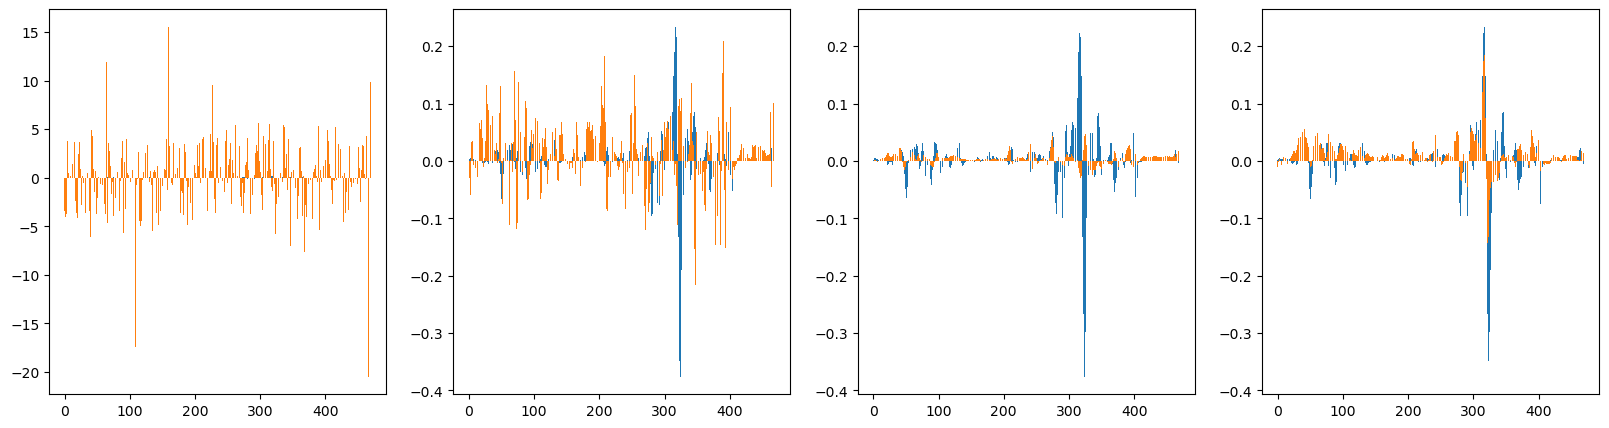

<Figure size 640x480 with 0 Axes>

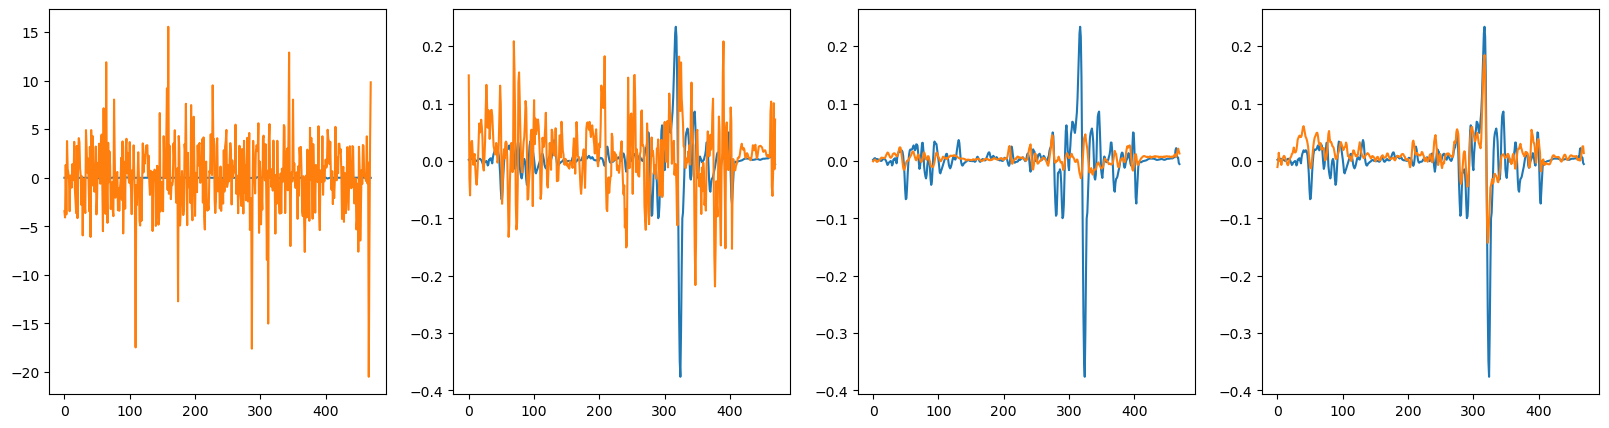

,linear_output,conv1d_output,build_deep_nn,build_encoder
0,5.130391,0.005901,0.001929,0.001764
1,10.000000,99.000000,95.000000,48.000000
2,0.040438,0.097864,0.329481,0.352009


In [ ]:
dataset_name = 'Beef'
fcn_ig = predict_attributions_head_2('fcn', dataset_name,'ig')
display(fcn_ig)

./results/ucr/Beef/experiment_1/resnet/resnet_0/original/best_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/Beef//experiment_1/resnet/resnet_0/original/best_model.hdf5
1/1 [==============================] - 0s 105ms/step


C:\Users\boent\AppData\Local\Temp\ipykernel_5228\3507783634.py:134: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd), ignore_index=True)


<Figure size 640x480 with 0 Axes>

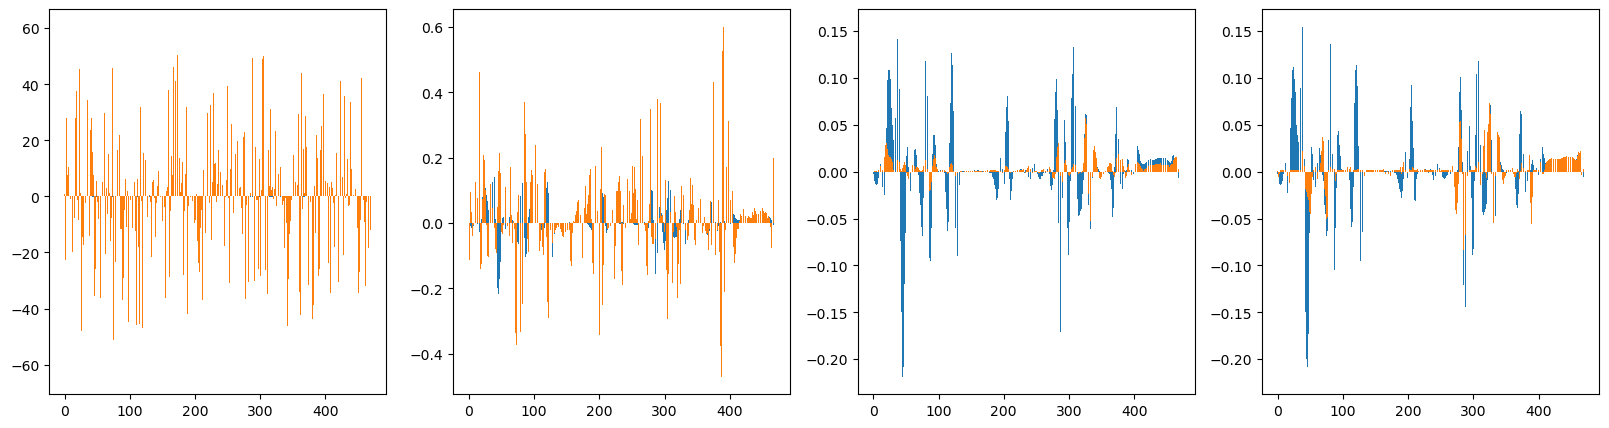

<Figure size 640x480 with 0 Axes>

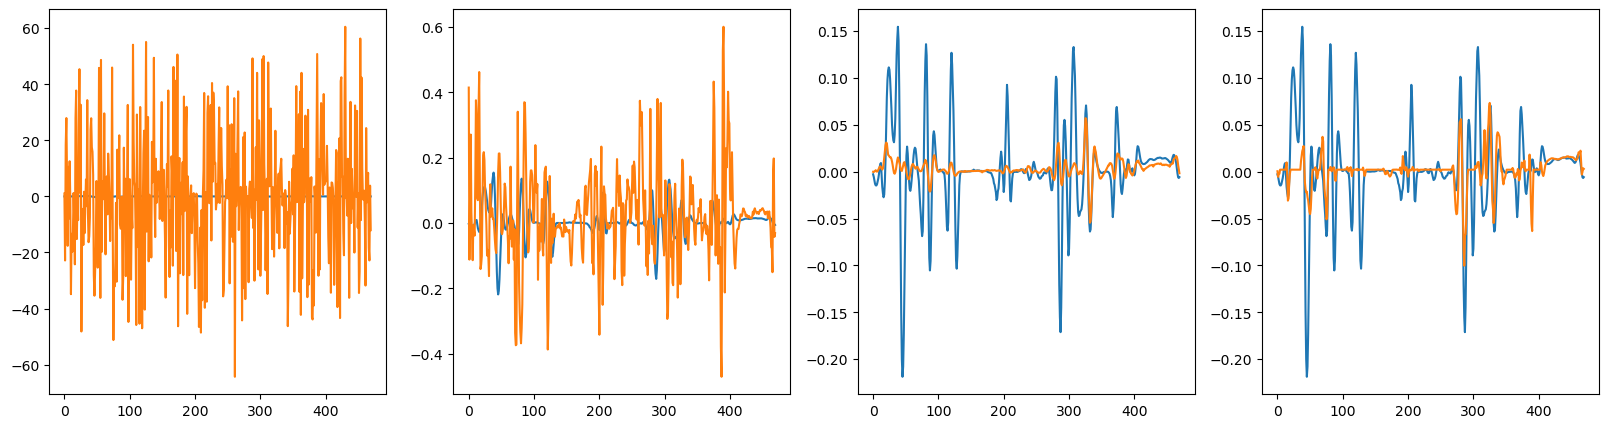

,linear_output,conv1d_output,build_deep_nn,build_encoder
0,20.665283,0.023853,0.002135,0.002063
1,83.000000,97.000000,29.000000,67.000000
2,0.025321,0.008170,0.052127,0.136272


In [ ]:
dataset_name = 'Beef'
resnet_ig = predict_attributions_head_2('resnet', dataset_name,'ig')
display(resnet_ig)

### ECG200

./results/ucr/ECG200/experiment_1/fcn/fcn_0/original/best_model.hdf5
/content/drive/My Drive/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_1/fcn/fcn_0/original/best_model.hdf5
4/4 [==============================] - 0s 3ms/step
0 0
0 1
0 2
1 1


<Figure size 640x480 with 0 Axes>

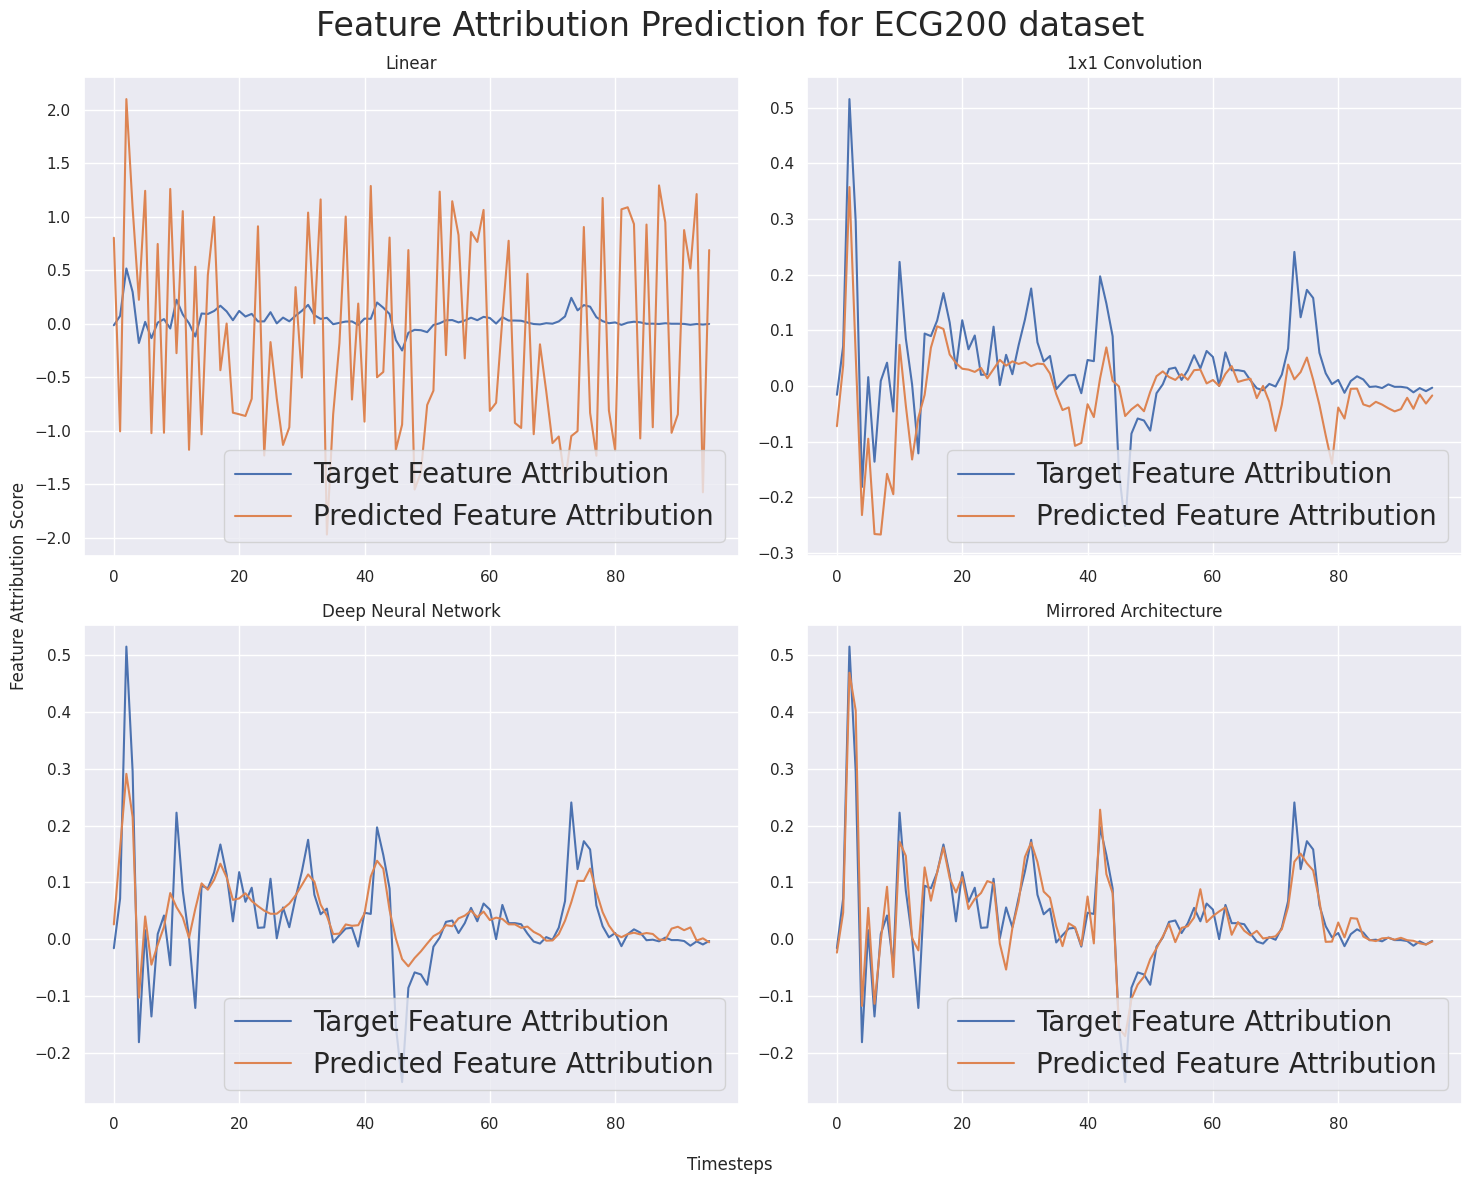

0
1


<Figure size 640x480 with 0 Axes>

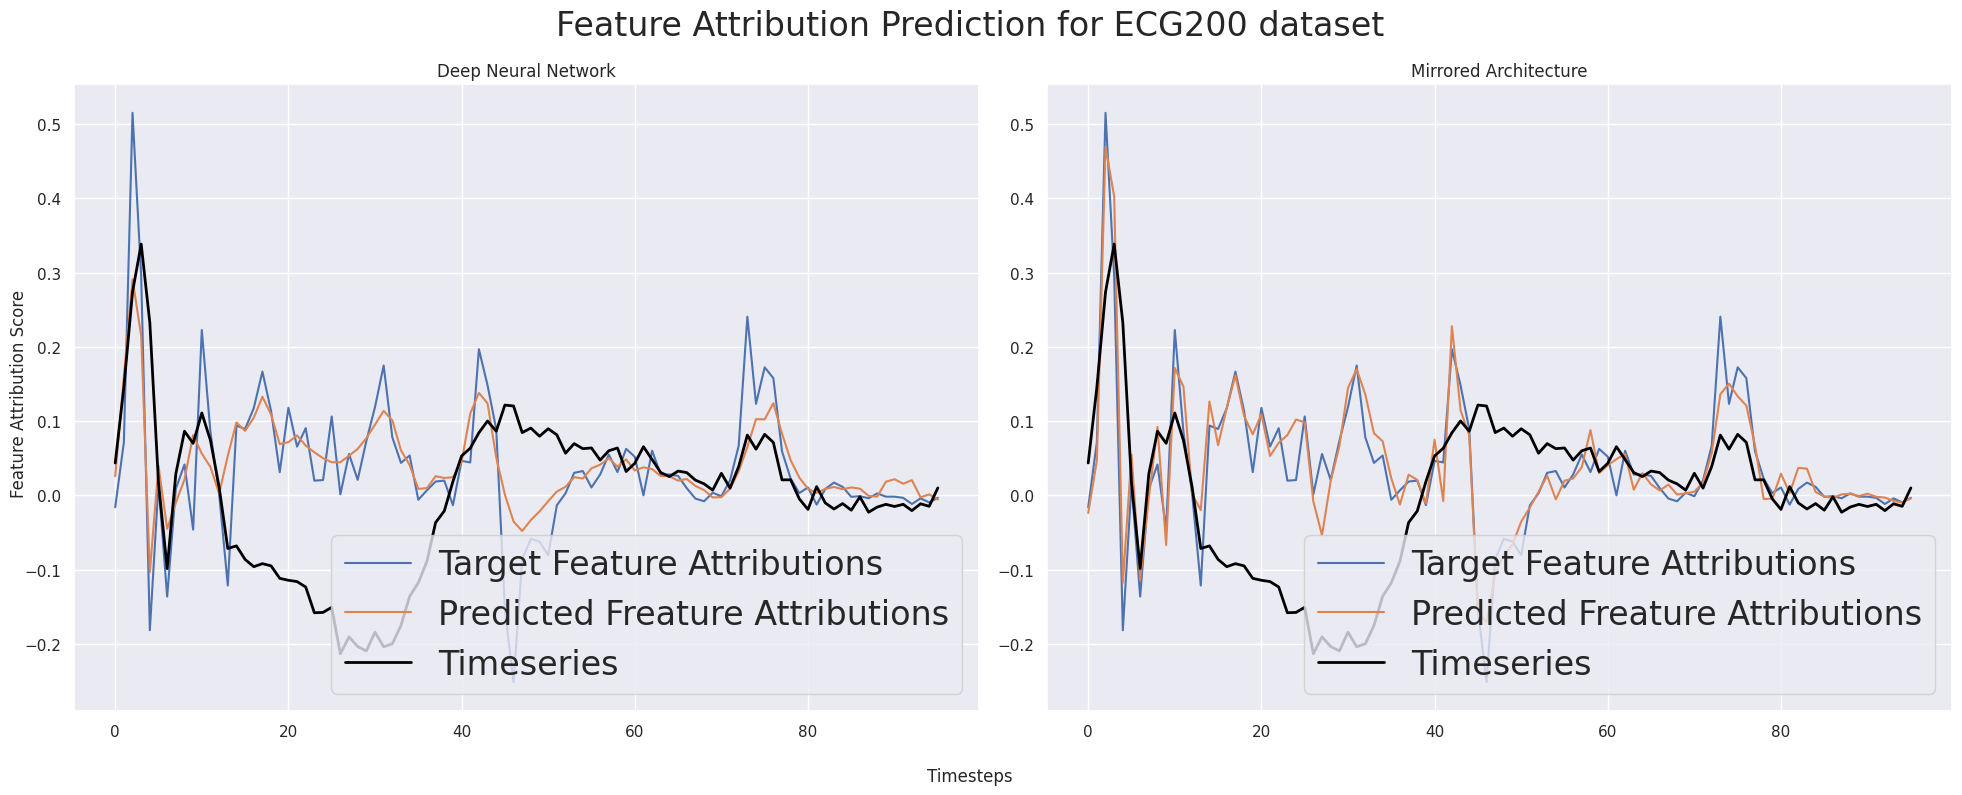

,linear_output,conv1d_output,build_deep_nn,build_encoder


In [26]:
dataset_name = 'ECG200'
fcn_ig = predict_attributions_head_2('fcn', dataset_name,'ig')
display(fcn_ig)

In [ ]:
dataset_name = 'ECG200'
resnet_ig = predict_attributions_head_2('resnet', dataset_name,'ig')
display(resnet_ig)

./results/ucr/ECG200/experiment_1/resnet/resnet_0/original/best_model.hdf5
G:/Meine Ablage/master thesis/code/xai-tsc/results/ucr/ECG200//experiment_1/resnet/resnet_0/original/best_model.hdf5
4/4 [==============================] - 0s 30ms/step


C:\Users\boent\AppData\Local\Temp\ipykernel_14212\2465729710.py:135: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  results = results.append(pd.DataFrame(metric_pd), ignore_index=True)
C:\Users\boent\AppData\Local\Temp\ipykernel_14212\2465729710.py:147: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()
C:\Users\boent\AppData\Local\Temp\ipykernel_14212\2465729710.py:162: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  plt.show()


,linear_output,conv1d_output,build_deep_nn,build_encoder
0,1.316970,0.006160,0.006550,0.004042
1,350.000000,397.000000,209.000000,332.000000
2,-0.016219,0.631404,0.357371,0.745135


### Visualization



1/1 [==============================] - 0s 402ms/step


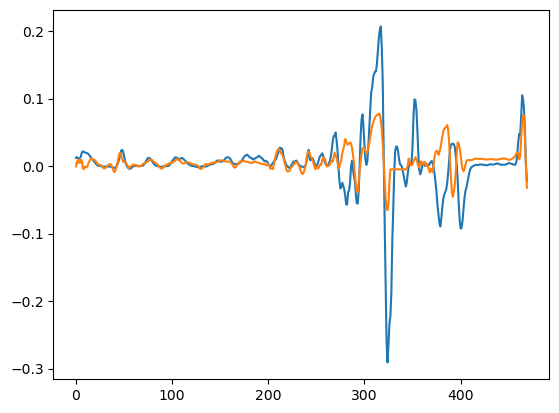

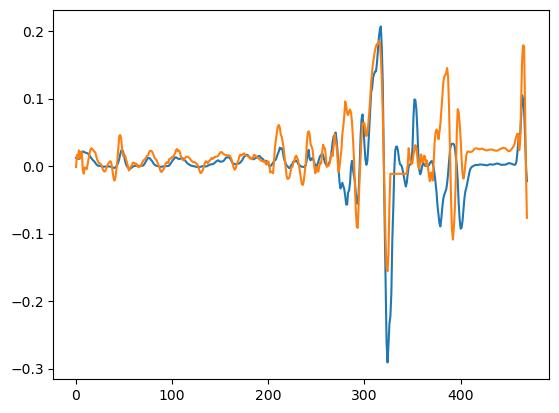

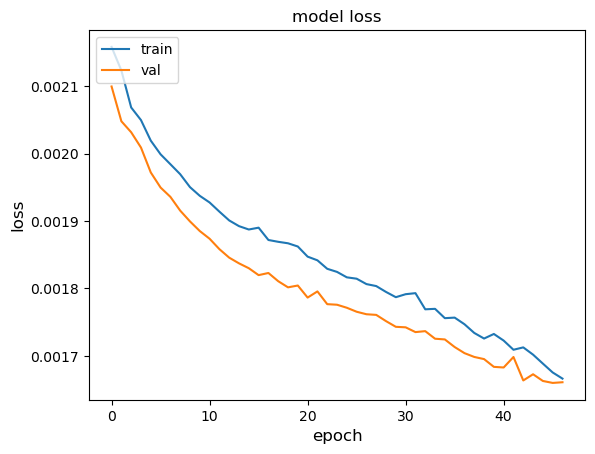

In [ ]:
%matplotlib inline
ts = 25

plt.plot(y_val_2[ts])
pr = final_model.predict(x_test)
#print(pr[1][ts])
plt.plot(pr[1][ts])
plt.show()


plt.plot(norm(y_val_2[ts]))
plt.plot(norm(pr[1][ts]))
skip_first_epochs = 3

metric = "loss"
plt.figure()
plt.plot(hist.history[metric][skip_first_epochs:])
plt.plot(hist.history['val_' + metric][skip_first_epochs:])
plt.title('model ' + metric)
plt.ylabel(metric, fontsize='large')
plt.xlabel('epoch', fontsize='large')
plt.legend(['train', 'val'], loc='upper left')